# Mentis Emotion Classification – End‑to‑End Notebook
This notebook:
1. Downloads the **“Journal entries with labelled emotions”** dataset from Kaggle  
2. Cleans & validates the data  
3. Splits into train / validation / test  
4. Fine‑tunes **DistilBERT‑base‑uncased** for **multi‑label emotion classification**  
5. Plots training metrics & label distribution  
6. Saves and **zips** the fine‑tuned model  
7. Generates a spider‑chart profile (6 parent emotions) for any text  
---


## 🔧 Setup

In [ ]:
%pip install -q --upgrade \
    torch==2.3.0 \
    torchvision==0.18.0 \
    torchaudio==2.3.0 \
    transformers==4.46.0 \
    datasets==2.19.1 \
    accelerate==0.29.3 \
    scikit-learn==1.5.0 \
    evaluate==0.4.2 \
    matplotlib seaborn ipywidgets

In [ ]:
import transformers, torch
print(transformers.__version__)   # → 4.46.0
print(torch.__version__)          # → 2.2.2

## 📥 Download dataset from Kaggle

In [1]:
from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt, re, os, shutil

# Direct path to the CSV as Kaggle mounts it
csv_path = Path("/kaggle/input/journal-entries-with-labelled-emotions/data.csv")

# Quick sanity-check
if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found — verify the dataset slug in ‘Add Data’ pane")

print("CSV path set to:", csv_path)


CSV path set to: /kaggle/input/journal-entries-with-labelled-emotions/data.csv


## 🧹 Data Loading & Quick Glimpse

In [2]:
import pandas as pd, numpy as np

# Load data
df = pd.read_csv(csv_path)

# Clean up label column names
label_clean_map = {col: col.replace("Answer.f1.", "").replace(".raw", "") 
                   for col in df.columns if col.startswith("Answer.f1.") and col.endswith(".raw")}
df.rename(columns=label_clean_map, inplace=True)

# Keep only emotion labels
emotion_labels = [
    'afraid', 'angry', 'anxious', 'ashamed', 'awkward', 'bored', 'calm',
    'confused', 'disgusted', 'excited', 'frustrated', 'happy', 'jealous',
    'nostalgic', 'proud', 'sad', 'satisfied', 'surprised'
]
label_cols = emotion_labels
text_col = 'Answer'

# Confirm
print("Label columns:", label_cols)
print(df.head())
print("\nShape:", df.shape)


Label columns: ['afraid', 'angry', 'anxious', 'ashamed', 'awkward', 'bored', 'calm', 'confused', 'disgusted', 'excited', 'frustrated', 'happy', 'jealous', 'nostalgic', 'proud', 'sad', 'satisfied', 'surprised']
                                              Answer  afraid  angry  anxious  \
0  My family was the most salient part of my day,...   False  False     True   
1  Yoga keeps me focused. I am able to take some ...   False  False    False   
2  Yesterday, my family and I played a bunch of b...   False  False    False   
3  Yesterday, I visited my parents and had dinner...   False  False    False   
4  Yesterday, I really felt the importance of my ...   False  False    False   

   ashamed  awkward  bored   calm  confused  disgusted  ...  \
0    False    False  False  False     False      False  ...   
1    False    False  False   True     False      False  ...   
2    False    False  False   True     False      False  ...   
3    False    False  False   True     False      False  .

### 🔍 Detect label columns

### 🩺 Data Validation & Cleaning

In [3]:
df[label_cols] = df[label_cols].astype(int)
df[text_col] = df[text_col].astype(str).fillna("")
assert not df[text_col].isna().any()

print("Nulls per column:")
print(df[label_cols + [text_col]].isna().sum())


Nulls per column:
afraid        0
angry         0
anxious       0
ashamed       0
awkward       0
bored         0
calm          0
confused      0
disgusted     0
excited       0
frustrated    0
happy         0
jealous       0
nostalgic     0
proud         0
sad           0
satisfied     0
surprised     0
Answer        0
dtype: int64


### 📊 Label distribution

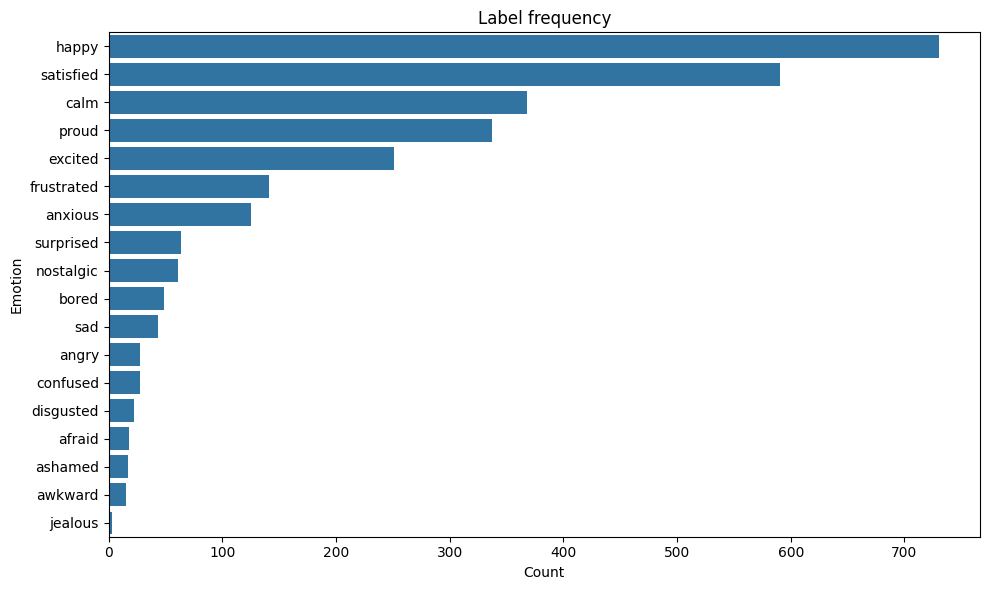

In [4]:
import seaborn as sns, matplotlib.pyplot as plt
label_freq = df[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=label_freq.values, y=label_freq.index)
plt.title("Label frequency")
plt.xlabel("Count"); plt.ylabel("Emotion")
plt.tight_layout()

## ✂️ Train / Validation / Test Split

In [5]:
## ✂️ Train / Validation / Test Split
from sklearn.model_selection import train_test_split
import numpy as np

# Convert multi-label row to a dominant-class index
y_single = df[label_cols].values.argmax(axis=1)

# How many samples per (dominant) class?
_, counts = np.unique(y_single, return_counts=True)

# If any class has <2 samples, skip stratification
if np.any(counts < 2):
    print("⚠️ Not enough samples to stratify — using random split instead.")
    train_df, temp_df = train_test_split(
        df, test_size=0.2, random_state=42, shuffle=True
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, shuffle=True
    )
else:
    train_df, temp_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=y_single
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=y_single[temp_df.index],
    )

# 🔍 Sanity-check: any label missing from the training set?
missing = train_df[label_cols].sum() == 0
if missing.any():
    print("⚠️ Labels absent from training:", missing[missing].index.tolist())

print("✅ Split complete → Train:", len(train_df),
      "Val:", len(val_df),
      "Test:", len(test_df))


⚠️ Not enough samples to stratify — using random split instead.
✅ Split complete → Train: 1178 Val: 147 Test: 148


### 🤗 Create HF Datasets

In [6]:
from datasets import Dataset, DatasetDict

def df_to_ds(pdf):
    return Dataset.from_pandas(pdf[[text_col]+label_cols])

ds = DatasetDict({
    "train": df_to_ds(train_df),
    "validation": df_to_ds(val_df),
    "test": df_to_ds(test_df)
})
ds

DatasetDict({
    train: Dataset({
        features: ['Answer', 'afraid', 'angry', 'anxious', 'ashamed', 'awkward', 'bored', 'calm', 'confused', 'disgusted', 'excited', 'frustrated', 'happy', 'jealous', 'nostalgic', 'proud', 'sad', 'satisfied', 'surprised', '__index_level_0__'],
        num_rows: 1178
    })
    validation: Dataset({
        features: ['Answer', 'afraid', 'angry', 'anxious', 'ashamed', 'awkward', 'bored', 'calm', 'confused', 'disgusted', 'excited', 'frustrated', 'happy', 'jealous', 'nostalgic', 'proud', 'sad', 'satisfied', 'surprised', '__index_level_0__'],
        num_rows: 147
    })
    test: Dataset({
        features: ['Answer', 'afraid', 'angry', 'anxious', 'ashamed', 'awkward', 'bored', 'calm', 'confused', 'disgusted', 'excited', 'frustrated', 'happy', 'jealous', 'nostalgic', 'proud', 'sad', 'satisfied', 'surprised', '__index_level_0__'],
        num_rows: 148
    })
})

## 🏷️ Tokenization

In [7]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)

# Tokenize text
def tokenize(batch):
    return tok(batch[text_col], truncation=True, padding='max_length', max_length=128)

ds_tok = ds.map(tokenize, batched=True)

# Add emotion labels as 'labels' field
def add_labels(example):
    example['labels'] = [float(example[e]) for e in label_cols]
    return example

ds_tok = ds_tok.map(add_labels)

# Final format for Trainer
ds_tok.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/1178 [00:00<?, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Map:   0%|          | 0/1178 [00:00<?, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

## 🧠 Define Model for Multi‑label Classification

In [8]:
from transformers import AutoModelForSequenceClassification
num_labels = len(label_cols)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels, problem_type="multi_label_classification")

2025-07-08 09:51:18.690146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751968278.714117     203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751968278.721502     203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 📐 Metrics (micro‑ & macro‑F1, accuracy)

In [28]:
import numpy as np, torch
from sklearn.metrics import f1_score, accuracy_score


val_logits, val_labels = trainer.predict(ds_tok["validation"])[:2]
val_probs = torch.sigmoid(torch.tensor(val_logits)).numpy()

ths = np.linspace(0.10, 0.45, 12)          # refined grid
best_thresholds = []
for i in range(val_labels.shape[1]):
    best_f1, best_t = 0.0, ths[0]
    for t in ths:                           # pick the t with highest F1
        f1 = f1_score(
            val_labels[:, i],
            (val_probs[:, i] > t).astype(int),
            zero_division=0,
        )
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thresholds.append(best_t)
best_thresholds = np.array(best_thresholds)
print("👉 Refined thresholds:", best_thresholds)


def compute_metrics(pred):
    logits, labels = pred
    probs  = torch.sigmoid(torch.tensor(logits)).numpy()
    y_pred = (probs > best_thresholds).astype(int)

    # ---- optional “top-1 guarantee” ----
    empty_rows = y_pred.sum(axis=1) == 0
    if empty_rows.any():
        top1 = probs[empty_rows].argmax(axis=1)
        y_pred[empty_rows, top1] = 1
    # ------------------------------------

    return {
        "micro_f1": f1_score(labels, y_pred, average="micro", zero_division=0),
        "macro_f1": f1_score(labels, y_pred, average="macro", zero_division=0),
        "accuracy": accuracy_score(labels, y_pred),
    }


👉 Refined best thresholds per label: [0.1        0.1        0.32272727 0.1        0.1        0.16363636
 0.13181818 0.1        0.1        0.35454545 0.29090909 0.19545455
 0.1        0.1        0.1        0.38636364 0.19545455 0.1       ]


## [](http://)🚀 Fine‑Tune DistilBERT

In [12]:

from transformers import (TrainingArguments, Trainer, set_seed,
                          AutoModelForSequenceClassification)
import torch, numpy as np
from sklearn.metrics import f1_score, accuracy_score

# ── 1. Reproducibility ───────────────────────────────────────────────
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 2. Compute per-label weights  w_i = (1-p_i)/p_i  ────────────────
p = df[label_cols].mean().values                # positive rates
pos_weight = ((1 - p) / p).tolist()             # convert to *list*, not tensor

# ── 3. Model ----------------------------------------------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)
model.to(device)

model.config.pos_weight = pos_weight           

# ── 4. Metrics with threshold 0.25 ───────────────────────────────────
THRESHOLD = 0.25
def compute_metrics(pred):
    logits, labels = pred
    probs  = torch.sigmoid(torch.tensor(logits)).numpy()
    y_pred = (probs > THRESHOLD).astype(int)
    micro  = f1_score(labels, y_pred, average="micro", zero_division=0)
    macro  = f1_score(labels, y_pred, average="macro", zero_division=0)
    acc    = accuracy_score(labels, y_pred)
    return {"micro_f1": micro, "macro_f1": macro, "accuracy": acc}

# ── 5. Training arguments ────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir="model_out",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
)

# ── 6. Trainer & train ───────────────────────────────────────────────
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    compute_metrics=compute_metrics,
)
trainer.train()                          

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.331400
100,0.255600
150,0.229200
200,0.214900
250,0.192900
300,0.183100
350,0.153800
400,0.134500
450,0.114700
500,0.093500


TrainOutput(global_step=740, training_loss=0.14843965092220823, metrics={'train_runtime': 79.8665, 'train_samples_per_second': 147.496, 'train_steps_per_second': 9.265, 'total_flos': 390227803822080.0, 'train_loss': 0.14843965092220823, 'epoch': 10.0})

## 🧪 Evaluate on Test Set

In [33]:
test_metrics = trainer.evaluate(ds_tok['test'])
print("📈 Test set evaluation:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")


📈 Test set evaluation:
eval_loss: 0.2880
eval_micro_f1: 0.5463
eval_macro_f1: 0.2666
eval_accuracy: 0.1053
eval_runtime: 0.3153
eval_samples_per_second: 482.0970
eval_steps_per_second: 31.7170
epoch: 10.0000


## 🏁 Additional evaluation metrics beyond Trainer.evaluate


In [34]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support,
    hamming_loss,
    jaccard_score,
)

# Get raw predictions on the test set
preds_test = trainer.predict(ds_tok['test'])
logits_test, labels_test = preds_test.predictions, preds_test.label_ids
probs_test = torch.sigmoid(torch.tensor(logits_test)).numpy()

# Apply best_thresholds to get binary predictions
y_pred = (probs_test > best_thresholds).astype(int)
y_true = labels_test

# Overall metrics
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='micro', zero_division=0
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)
hamming = hamming_loss(y_true, y_pred)
jaccard = jaccard_score(y_true, y_pred, average='samples')

print("🔍 Detailed evaluation on the test set")
print(f"Micro  - Precision: {precision_micro:.4f} | Recall: {recall_micro:.4f} | F1: {f1_micro:.4f}")
print(f"Macro  - Precision: {precision_macro:.4f} | Recall: {recall_macro:.4f} | F1: {f1_macro:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Score: {jaccard:.4f}")

# Per-label report
target_names = label_cols  # your emotion column names
print("\n📋 Classification report (per label):")
print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    zero_division=0
))

🔍 Detailed evaluation on the test set
Micro  - Precision: 0.5000 | Recall: 0.5877 | F1: 0.5403
Macro  - Precision: 0.3301 | Recall: 0.3540 | F1: 0.3222
Hamming Loss: 0.1126
Jaccard Score: 0.4001

📋 Classification report (per label):
              precision    recall  f1-score   support

      afraid       0.75      1.00      0.86         3
       angry       0.40      0.67      0.50         3
     anxious       0.70      0.50      0.58        14
     ashamed       0.00      0.00      0.00         2
     awkward       0.00      0.00      0.00         2
       bored       0.17      0.25      0.20         4
        calm       0.50      0.57      0.53        46
    confused       0.00      0.00      0.00         3
   disgusted       0.00      0.00      0.00         2
     excited       0.33      0.22      0.27        27
  frustrated       0.38      0.56      0.45         9
       happy       0.66      0.82      0.73        79
     jealous       0.00      0.00      0.00         2
   nostalg

## 💾 Save & Zip Model

In [35]:
from pathlib import Path
import zipfile

save_dir = Path("distilbert_emotion_finetuned_full")
save_dir.mkdir(exist_ok=True)

# Save model
trainer.save_model(save_dir)

# Save tokenizer
tok.save_pretrained(save_dir)

# Zip everything
zip_path = f"{save_dir}.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for file in save_dir.rglob("*"):
        zf.write(file, file.relative_to(save_dir.parent))

print("✅ Full model and tokenizer saved and zipped:", zip_path)


✅ Full model and tokenizer saved and zipped: distilbert_emotion_finetuned_full.zip


## 🕸️ Spider‑Chart Visualization (6 Parent Emotions)

In [29]:
parent_map = {
    "Good": [
        "happy", "proud", "excited", "satisfied"
    ],
    "Uneasy": [  # low-intensity discomfort
        "bored", "awkward", "ashamed", "nostalgic"
    ],
    "Struggling": [  # high-intensity negative states
        "sad", "angry", "frustrated", "jealous",
        "afraid", "anxious", "confused", "disgusted"
    ],
    "Neutral": [
        "surprised", "calm"
    ]
}


In [30]:
def spider_and_bar_from_text(text):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    device = model.device
    enc = tok(text, return_tensors="pt", truncation=True, padding='max_length', max_length=128).to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    # Map emotion scores
    emotion_scores = dict(zip(label_cols, probs))

    # ✅ Define parent_scores BEFORE printing
    parent_scores = {
        group: np.mean([emotion_scores[e] for e in members if e in emotion_scores])
        for group, members in parent_map.items()
    }

    # 🧠 Print top scoring group and emotions
    print("Top predicted emotions:")
    for e, p in sorted(emotion_scores.items(), key=lambda x: -x[1])[:5]:
        print(f"{e:<10}: {p:.3f}")
    
    print("\nDominant group:", max(parent_scores, key=parent_scores.get))

    # Sort emotion scores for bar plot
    sorted_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)
    emotion_names, emotion_vals = zip(*sorted_emotions)

    # ── Plot ──
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Spider chart
    cats = list(parent_scores.keys())
    vals = list(parent_scores.values()) + [list(parent_scores.values())[0]]  # close loop
    angles = np.linspace(0, 2 * np.pi, len(cats) + 1)

    ax = plt.subplot(121, polar=True)
    ax.plot(angles, vals, linewidth=2)
    ax.fill(angles, vals, alpha=0.3)
    ax.set_thetagrids(angles[:-1] * 180/np.pi, cats)
    ax.set_title("High-Level Emotional State")

    # Bar chart
    axs[1].barh(emotion_names[::-1], emotion_vals[::-1], color='skyblue')
    axs[1].set_title("Detailed Emotion Probabilities")
    axs[1].set_xlim(0, 1)
    axs[1].grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


## 

Top predicted emotions:
frustrated: 0.719
angry     : 0.150
disgusted : 0.111
sad       : 0.051
surprised : 0.044

Dominant group: Struggling


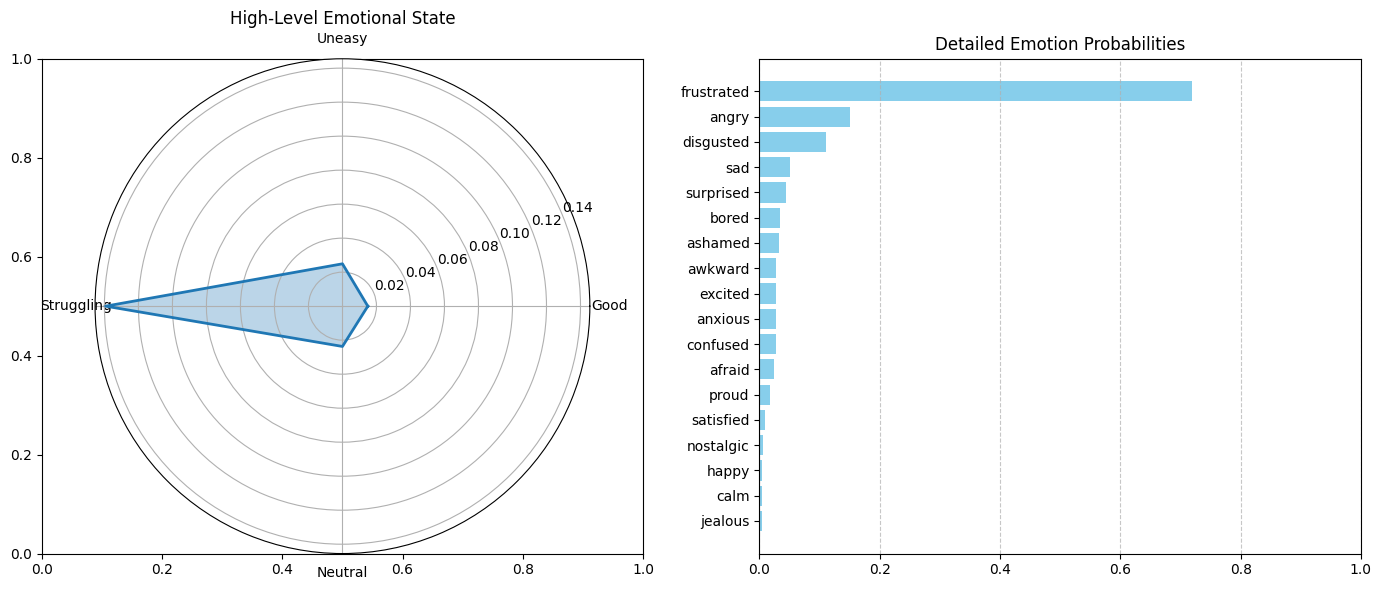

Top predicted emotions:
happy     : 0.991
proud     : 0.611
calm      : 0.294
satisfied : 0.233
excited   : 0.171

Dominant group: Good


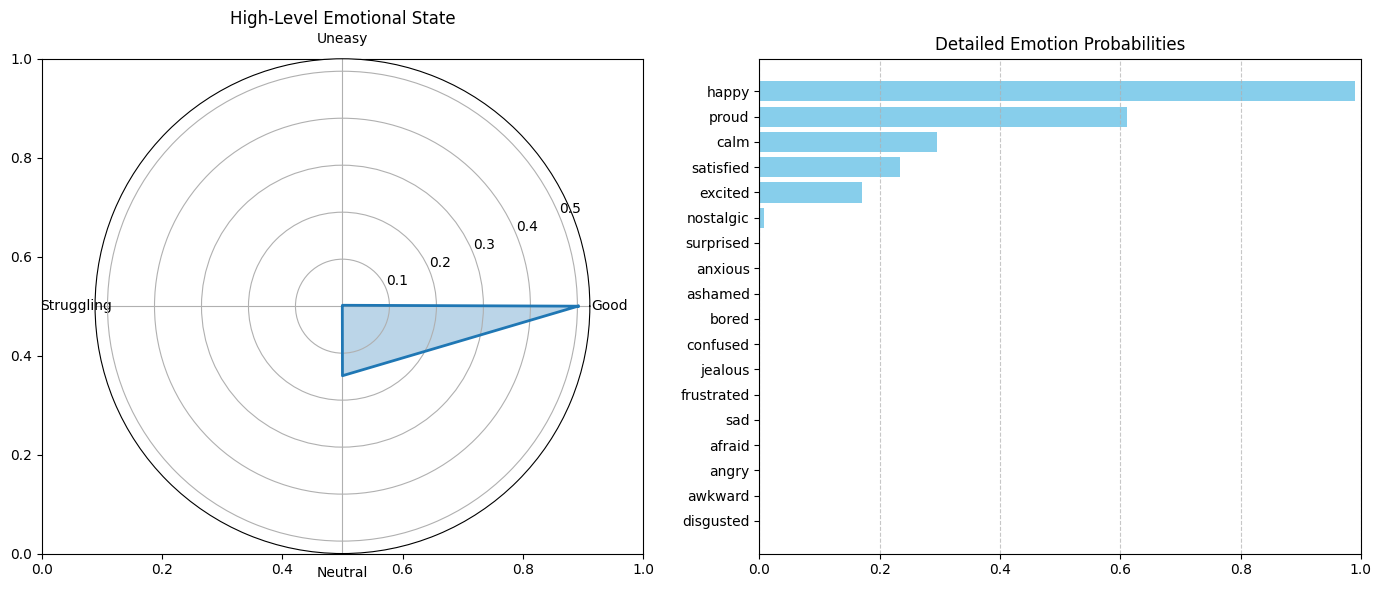

Top predicted emotions:
calm      : 0.321
proud     : 0.123
frustrated: 0.031
anxious   : 0.022
bored     : 0.016

Dominant group: Neutral


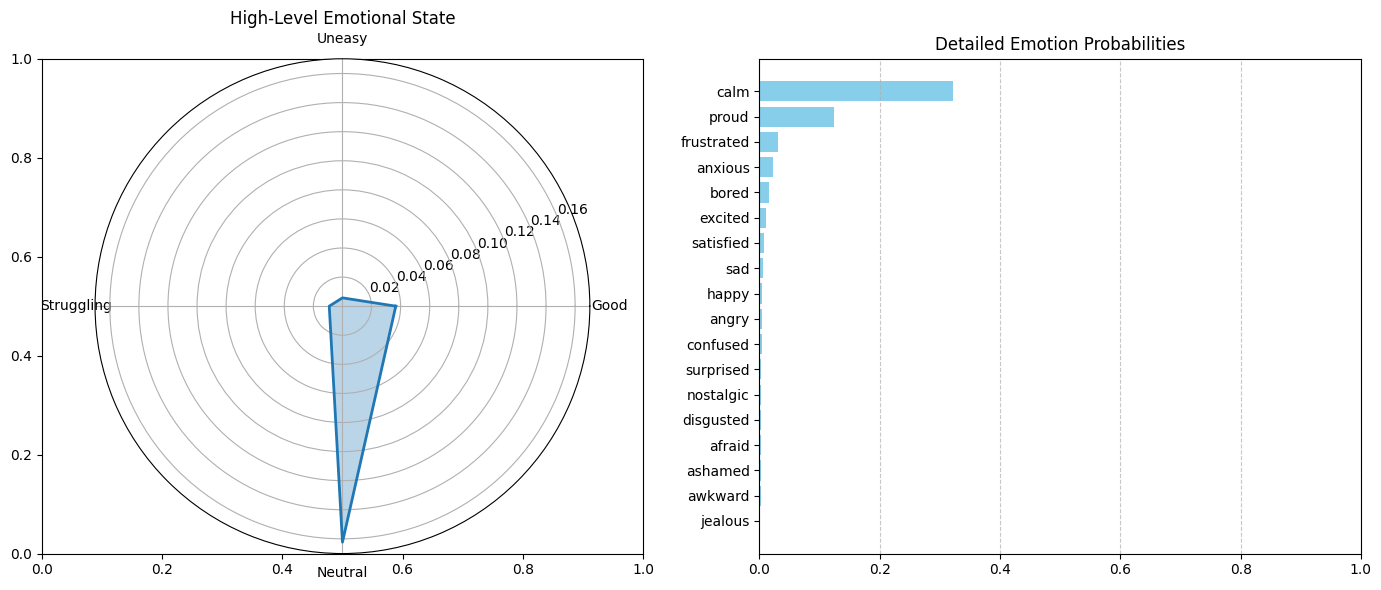

In [32]:
spider_and_bar_from_text("I had a really bad day, I felt disapointed of myself and genuinely shit.")
spider_and_bar_from_text("My day was perfect.")
spider_and_bar_from_text("Didn't had any issues this week, yet nothing exicting happaned as well")

## ✅ Notebook Complete

Use the _Save_ button or `File → Download → .ipynb` to grab this notebook, and download the zipped model at the path printed above.